In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

from abtem import GridScan,LineScan, PixelatedDetector, PotentialArray, Probe
from abtem.reconstruct import epie


In [2]:
from abtem.custom import get_potential
from abtem.utils import fft_shift


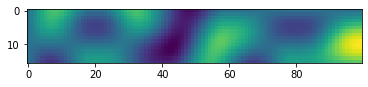

In [3]:
#Noise https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin[:16]) # FIX3: I thought I had to invert x and y here but it was a mistake

plt.imshow(perlin(x,y,seed=1),origin='upper')

# Reconstruction of weak phase object using the ePIE algorithm

Defining part of potential which creates $\frac{\pi}{2}\,\mathrm{rad}$ phase shift on electron beam traveling through the potential at $200\,\mathrm{keV}$ energy. 

In [4]:
energy = 200e3
C3 = 1.2e-3/1e-10 #In Angstrom
num = 1
#ex, extent are dummy
ex_dummy = 0.05e-6/1e-10 # A # sample dimensions in x and y direction # 
extent_dummy = np.array([ex_dummy, ex_dummy])
gpts=np.array([256,64])
#sampling = extent/gpts
phase_shift = np.pi/2 #rad
potential_phase_plate = get_potential(phase_shift=phase_shift,extent=extent_dummy,energy=energy,gpts=gpts,num=num)

[1.953125 7.8125  ]


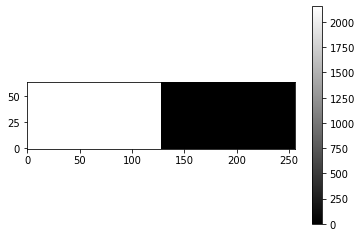

In [5]:
plt.imshow(potential_phase_plate.array[0].T,origin="lower",cmap="gray");plt.colorbar()

In [6]:
potential_phase_plate_max=np.max(potential_phase_plate.array[0])

Defining second part of the potential which has truncated perlin noise which ranges from 0 to $1/10$ of the amplitude of phase plate potential above.

(-0.5, 255.5, 63.5, -0.5)

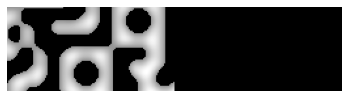

In [7]:
sampling = 0.5
extent_x = sampling*gpts[0]
lin = np.linspace(0,1/2e1*extent_x/sampling,gpts[0],endpoint=False)
x,y = np.meshgrid(lin[0:gpts[1]],lin)
noise=perlin(x,y,seed=1)
noise=noise-np.min(noise)
noise[noise<0.5]=0
noise[y>np.max(y)/2]=0
noise=noise/np.max(noise)
noise=noise*potential_phase_plate_max/10
plt.imshow(noise.T,origin='upper',cmap="gray")
plt.axis("off")

Total defining potential as sum of both previouse potentials

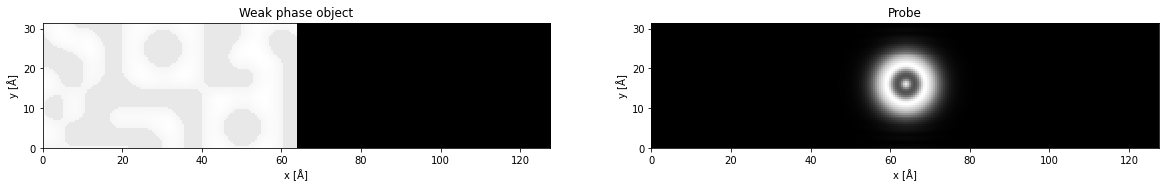

In [8]:
image = potential_phase_plate.array[0]+noise
defocus = 2000
semiangle_cutoff=7
probe = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy, C12=0 ,defocus=defocus, Cs=C3)
potential = PotentialArray(image[None], [0.], sampling=sampling)
probe.grid.match(potential)

fig,(ax1,ax2)= plt.subplots(1,2, figsize=(20,5))
potential.project().show(ax=ax1, title='Weak phase object')
probe.show(ax=ax2, title='Probe');

In [9]:
#plt.figure(figsize = (20,8))
#plt.imshow(image.T,origin='upper',cmap="gray")

In [10]:
center=np.array(potential.extent)/2
offset=np.array([center[0],center[1]/4])

In [11]:
print(offset)

[64.  4.]


We simulate 2304 diffraction patterns covering the entire test object.

In [12]:
probe_sampling=5 #20 will suceed but without contrast on large scales# 18 will succeed but large scale contrast will take time to be obtained 15 will suceed and on 120 iterations it will converge to ok contrast.
gridscan = GridScan(center-offset, center+offset, sampling=probe_sampling)
#gridscan = GridScan((0,0), potential.extent, sampling=probe_sampling)
detector = PixelatedDetector(None)
measurement = probe.scan(gridscan, [detector], potential)

Scan:   0%|          | 0/52 [00:00<?, ?it/s]

(-0.5, 255.5, -0.5, 63.5)

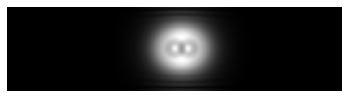

In [13]:
probe_A = np.abs(probe.build().array[0])
probe_B = np.abs(fft_shift(probe.build().array[0],np.array([probe.gpts[0]*probe_sampling/probe.extent[0],0])))
plt.imshow((probe_A+probe_B).T,cmap="gray",origin="lower")
plt.axis("off")

Note, as can be seen below, abTEM use a 2/3 antialising aperture.

We have to define our guess for the probe.

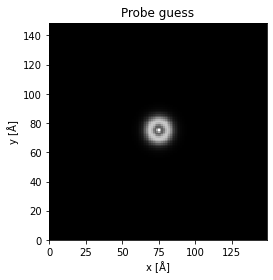

In [14]:
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy,defocus=defocus, C12=0, extent=150, gpts=128)
probe_guess.show(title='Probe guess');

Run the ePIE algorithm.

In [15]:
reconstructions = epie(measurement, probe_guess, maxiter=480, alpha=.25*5, return_iterations=True, fix_com=False, device='cpu')

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

The result after each iteration is shown below.

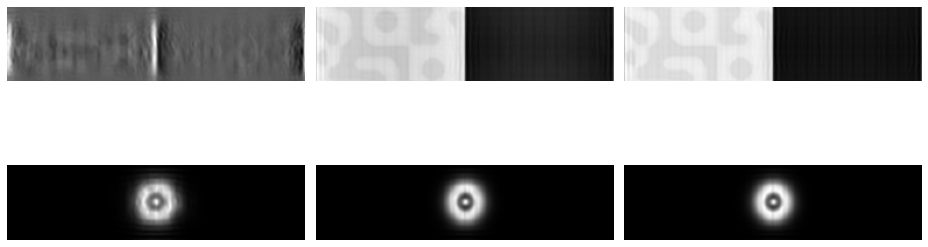

In [16]:
plot_every = 160

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(13,5.8))

for i, j in enumerate(range(0,len(reconstructions[0]),plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][j].array).T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

Probe intensity obtained from the last iteration of ePIE algorithm

(-0.5, 255.5, -0.5, 63.5)

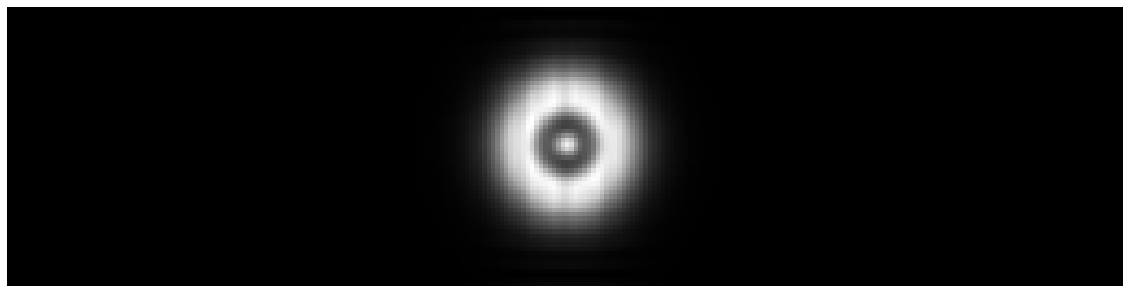

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(np.abs(reconstructions[1][-1].array).T ** 2, origin='lower', cmap='gray')
plt.axis("off")

Sample of STEM diffraction image from single probe position

(-0.5, 255.5, -0.5, 63.5)

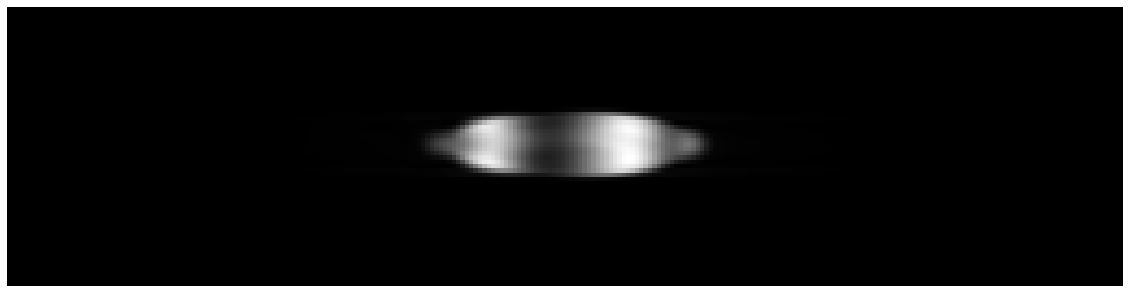

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(measurement.array[0,0].T, origin='lower',cmap='gray')
plt.axis("off")

In [19]:
%matplotlib qt
plt.imshow(measurement.array[0,0])

Phase shift estimate obtained from the last iteration of ePIE algorithm. In the image there can be seen some artefacts but the phase estimate seems to be on the average close to the specified phase shift. 

In [26]:
%matplotlib qt
plt.figure(figsize=(20,20))
im=np.angle(reconstructions[0][-1].array)
im=im-np.min(im)
plt.imshow(im.T, origin='lower', cmap='gray'); plt.colorbar();plt.axis("off")

(-0.5, 255.5, -0.5, 63.5)

In [21]:
%matplotlib qt
plt.figure(figsize=(20,20))
plt.imshow(np.angle(reconstructions[0][230].array).T, origin='lower', cmap='gray'); plt.colorbar();plt.axis("off")

(-0.5, 255.5, -0.5, 63.5)

In [22]:
probe.wavelength/9e-3

2.7865933685920523